# To html
python -m nbconvert --to html research.ipynb

# Load price data


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

path = "C:/Users/itataurov.KORECAPITAL/Desktop/ccxt_data/data_parsed/1d/technical/binance/joined/binance_perps_joined.parquet"

df = pd.read_parquet(path)
df.rename(columns={'datetime':'timestamp'}, inplace=True)
df = df.sort_values(by=['timestamp'])

df.head()

,symbol,timestamp,open,high,low,close,volume,mkt_cap,fundingRate,oi,...,buy_trades_perp,total_trades_perp,spot_close,buy_volume_spot,total_volume_spot,buy_trades_spot,total_trades_spot,predicted_funding_rate,short_liquidation_volume,long_liquidation_volume
0,BTC,2019-09-08,10000.00,10412.65,10000.00,10391.63,3096.291,1.862977e+11,NaN,NaN,...,NaN,NaN,10381.18,10583.392061,23977.212617,99471.0,208843.0,NaN,NaN,NaN
1,BTC,2019-09-09,10316.62,10475.54,10077.22,10307.00,14824.373,1.854112e+11,NaN,NaN,...,NaN,NaN,10303.12,18729.472684,39835.727608,141490.0,289009.0,NaN,NaN,NaN
2,BTC,2019-09-10,10307.00,10382.97,9940.87,10102.02,9068.955,1.824183e+11,0.0003,NaN,...,NaN,NaN,10098.15,13430.583727,28911.844232,122732.0,251048.0,NaN,NaN,NaN
3,BTC,2019-09-11,10094.27,10293.11,9884.31,10159.55,10897.922,1.830630e+11,0.0003,NaN,...,NaN,NaN,10158.33,16580.247908,31946.418957,145852.0,270589.0,NaN,NaN,NaN
4,BTC,2019-09-12,10163.06,10450.13,10042.12,10415.13,15609.634,1.864050e+11,0.0003,NaN,...,4748.0,9848.0,10415.01,18529.736860,34461.558090,142940.0,271187.0,NaN,NaN,NaN


# Universe growth

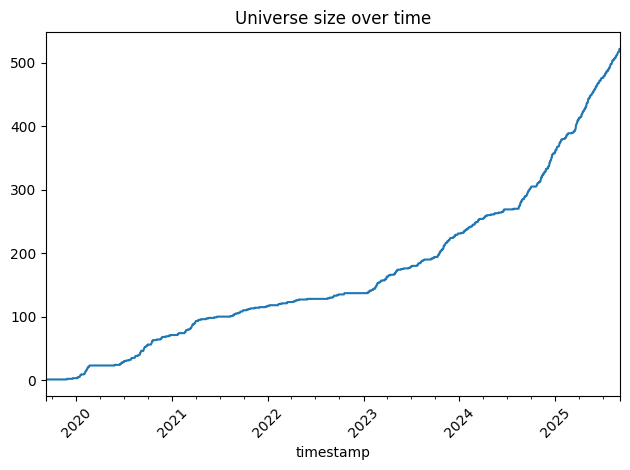

In [2]:
# plot universe size over time
df.groupby('timestamp').size().plot()
plt.title("Universe size over time")
plt.xticks(rotation=45)
plt.tight_layout()

# Forward returns

In [3]:
# Add forward returns
def add_n_day_forward_returns(df, n):
	# print(f"Adding {n} period forward returns")
	df[f"fwd_return_{n}d"] = (
		df.groupby("symbol")["close"]
		.transform(lambda x: x.shift(-n) / x - 1)
	)
	
	# Define a helper that computes the future sum using reversed rolling window
	def future_sum(series, n):
		# Reverse the series so that future values become the "past"
		rev = series.iloc[::-1]
		# Compute a rolling sum on the reversed series; use min_periods=n to only include rows with a full window
		rolled = rev.rolling(window=n, min_periods=n).sum().iloc[::-1]
		# Shift by -1 to align each row with the sum of the NEXT n periods (i.e., skip the current row)
		return rolled.shift(-1)
	
	# Apply the helper to each group and make sure to reset the index to match df
	df[f'fwd_funding_return_{n}d'] = df.groupby('symbol')['fundingRate'] \
									   .apply(lambda s: future_sum(s, n)) \
									   .reset_index(level=0, drop=True)
	# combined
	df[f'fwd_combined_return_{n}d'] = df[f'fwd_return_{n}d'] - df[f'fwd_funding_return_{n}d']
	return df

df.sort_values('timestamp', inplace=True)

for n in range(1, 61):
	df = add_n_day_forward_returns(df, n)

# copy df to de-fragment it
df = df.copy()

C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\3146204996.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'fwd_funding_return_{n}d'] = df.groupby('symbol')['fundingRate'] \
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\3146204996.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'fwd_combined_return_{n}d'] = df[f'fwd_return_{n}d'] - df[f'fwd_funding_return_{n}d']
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\3146204996.py:4: PerformanceWarning: DataFrame 

Funding rate is important to consider in modelling

In [4]:
# make vol a mix of long term(using expanding window) and short term (using ewm)
df['return'] = df.groupby('symbol')['close'].pct_change()
df['vol_expanding_window'] = (
	df.groupby('symbol')['return']
		.transform(lambda x: x
					.expanding(min_periods=30)
					.std())
)
df['vol_ewm'] = (
	df.groupby('symbol')['return']
		.transform(lambda x: x
					.ewm(span=30, adjust=False, min_periods=30)
					.std())
)
df['volatility'] = (
	df['vol_expanding_window'] * 0.25 +
	df['vol_ewm'] * 0.75
)

In [5]:
# Universe selection
df['dollar_volume'] = df['close'] * df['volume']
df['dollar_volume_slowed'] = df.groupby('symbol')['dollar_volume'].transform(lambda x: x.ewm(span=60, min_periods=30, adjust=False).mean())

df['dollar_volume_log'] = np.log1p(df['close'] * df['volume'])
df['dollar_volume_log_slowed'] = (
	df.groupby('symbol')['dollar_volume_log']
		.transform(lambda x: x.ewm(span=60, min_periods=30, adjust=False).mean())
)
df['dv_rank'] = (
	df.groupby('timestamp')['dollar_volume_log_slowed']
		.rank(method='first', ascending=False)
		.fillna(1000000)
		.astype(int)
)
df['dv_decile'] = df.groupby('timestamp')['dollar_volume_log_slowed'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')) + 1
df['dv_centile'] = df.groupby('timestamp')['dollar_volume_log_slowed'].transform(lambda x: pd.qcut(x, 100, labels=False, duplicates='drop')) + 1

df['market_cap_slowed'] = (
	df.groupby('symbol')['mkt_cap']
		.transform(lambda x: x.ewm(span=60, min_periods=30, adjust=False).mean())
)
df['mc_rank'] = (
	df.groupby('timestamp')['market_cap_slowed']
		.rank(method='first', ascending=False)
		.fillna(1000000)
		.astype(int)
)
df['mc_decile'] = df.groupby('timestamp')['market_cap_slowed'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')) + 1

# days since listing
df['days_since_listing'] = df.groupby('symbol').cumcount() + 1

# Compute signal

In [6]:
import signals

lookbacks = [1,2, 4, 8, 16, 32, 64, 128, 256]

for l in lookbacks:
	print(f"Computing signal for lookback {l}")
	df = signals._compute_bolmom(df, f'signal_{l}d', l)


Computing signal for lookback 1
Computing Bollinger Band momentum signal...
Computing signal for lookback 2
Computing Bollinger Band momentum signal...
Computing signal for lookback 4
Computing Bollinger Band momentum signal...
Computing signal for lookback 8
Computing Bollinger Band momentum signal...
Computing signal for lookback 16
Computing Bollinger Band momentum signal...
Computing signal for lookback 32
Computing Bollinger Band momentum signal...
Computing signal for lookback 64
Computing Bollinger Band momentum signal...
Computing signal for lookback 128
Computing Bollinger Band momentum signal...
Computing signal for lookback 256
Computing Bollinger Band momentum signal...


# Filter illiquids 

In [7]:
# Select universe
df_filtered = df[df.dollar_volume_slowed >= 5e6] # at least $5M daily volume 
df_filtered = df_filtered[df_filtered['days_since_listing'] >= 90] # at least 90 days since listing (need data for risk estimate)
df_filtered = df_filtered[df_filtered.timestamp<'2025-01-01']
df_filtered = df_filtered[df_filtered.timestamp>'2021-01-01']
print(f"Filtered down from {len(df)} to {len(df_filtered)} rows")

Filtered down from 371753 to 218811 rows


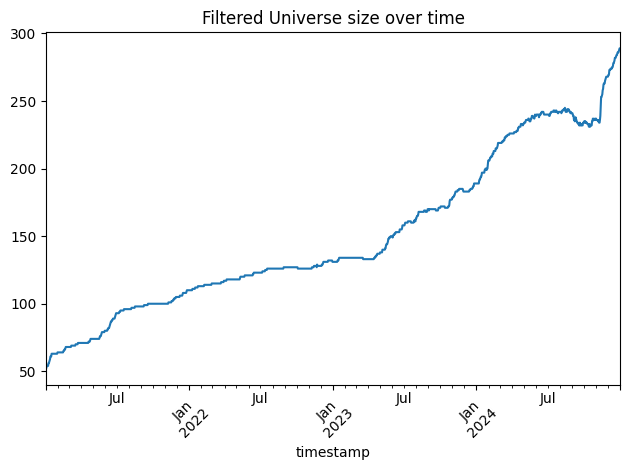

In [8]:
# plot universe size over time
df_filtered.groupby('timestamp').size().plot()
plt.title("Filtered Universe size over time")
plt.xticks(rotation=45)
plt.tight_layout()

In [9]:
# Demean forward returns cross-sectionally (by timestamp) (this is your target)
price_cols    = [f"fwd_return_{n}d"          for n in range(1, 61)]
funding_cols  = [f"fwd_funding_return_{n}d"  for n in range(1, 61)]
combined_cols = [f"fwd_combined_return_{n}d" for n in range(1, 61)]

for col in combined_cols:
    means = df_filtered.groupby("timestamp")[col].transform("mean")
    new_col = f"{col}_demeaned"
    df_filtered[new_col] = df_filtered[col] - means

df_filtered = df_filtered.copy() # de-fragment

In [10]:
# Create size score, log dv, zscore
df_filtered['size_score'] = df_filtered.groupby('timestamp')['dollar_volume_log'].transform(lambda x: (x - x.mean()) / x.std())
# clip size score to +/- 3
df_filtered['size_score'] = df_filtered['size_score'].clip(-4, 4)

Text(0.5, 1.0, 'Histogram of Size Score')

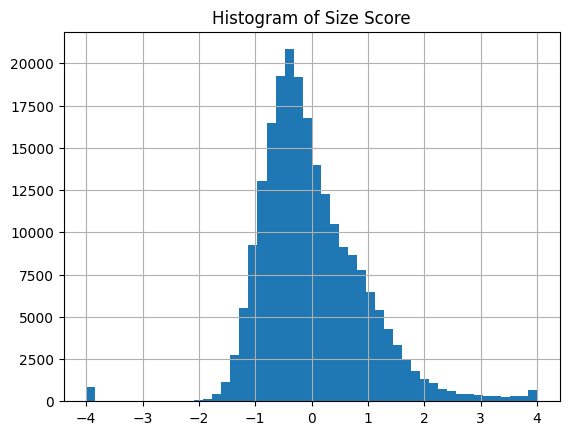

In [11]:
df_filtered['size_score'].hist(bins=50)
plt.title("Histogram of Size Score")

In [12]:
df_filtered.columns[0:30]

Index(['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume',
       'mkt_cap', 'fundingRate', 'oi', 'ls_ratio', 'longs_pct',
       'buy_volume_perp', 'total_volume_perp', 'buy_trades_perp',
       'total_trades_perp', 'spot_close', 'buy_volume_spot',
       'total_volume_spot', 'buy_trades_spot', 'total_trades_spot',
       'predicted_funding_rate', 'short_liquidation_volume',
       'long_liquidation_volume', 'fwd_return_1d', 'fwd_funding_return_1d',
       'fwd_combined_return_1d', 'fwd_return_2d', 'fwd_funding_return_2d',
       'fwd_combined_return_2d'],
      dtype='object')

# Visualize signals

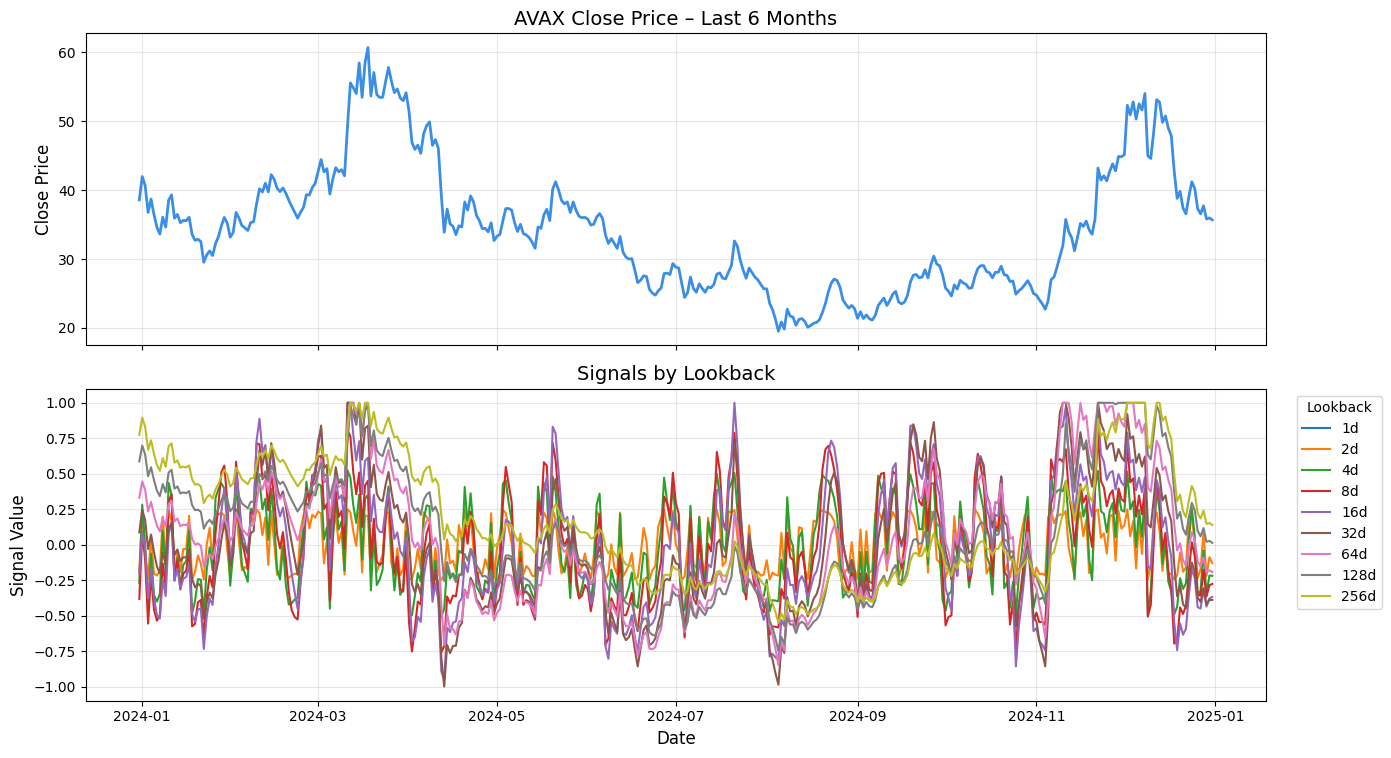

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# --- AVAX slice, last 12 months ----------------------------
btc = df_filtered[df_filtered['symbol'] == 'AVAX'].copy()
btc['timestamp'] = pd.to_datetime(btc['timestamp'])
end   = btc['timestamp'].max()
start = end - pd.DateOffset(months=12)
btc   = btc[btc['timestamp'] >= start]

# --- plot: price on top, signals bottom (equal height) ------------------
fig, (ax1, ax2) = plt.subplots(
	nrows=2,
	ncols=1,
	sharex=True,
	figsize=(14, 8),
	gridspec_kw={"height_ratios": [1, 1]}  # equal heights
)

# Top: AVAX price
ax1.plot(btc['timestamp'], btc['close'], color="#3B8EE5", lw=2)
ax1.set_ylabel('Close Price', fontsize=12)
ax1.set_title('AVAX Close Price – Last 6 Months', fontsize=14)
ax1.grid(True, alpha=0.3)

# Bottom: signals
for l in lookbacks:
	ax2.plot(
		btc['timestamp'],
		btc[f'signal_{l}d'],
		lw=1.5,
		label=f'{l}d'
	)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Signal Value', fontsize=12)
ax2.set_title('Signals by Lookback', fontsize=14)
ax2.legend(
	title='Lookback',
	bbox_to_anchor=(1.02, 1),
	loc='upper left'
)
ax2.grid(True, alpha=0.3)

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Lookback selection

### IC vs lookback

1
2


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\2409898226.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  avg_hold       = 1.0 / avg_turn


4
8
16
32
64
128
256


C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


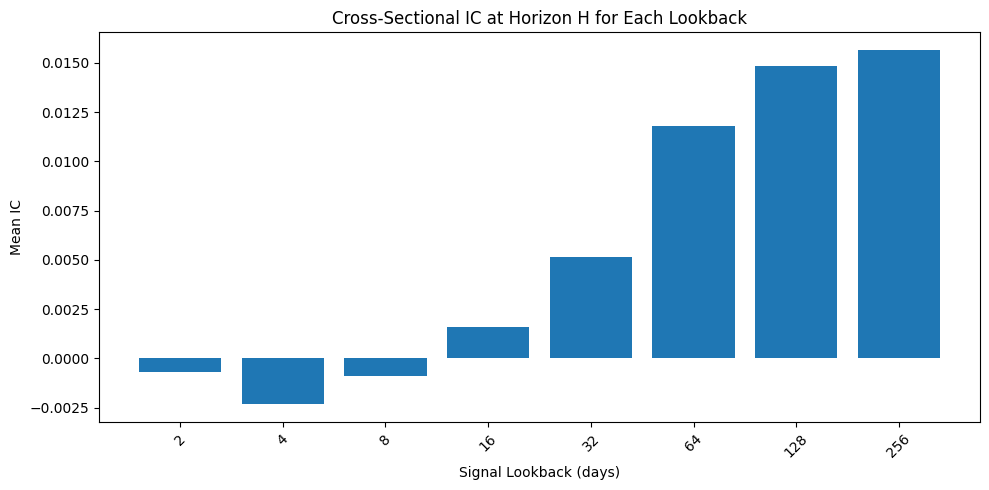

          avg_turnover  avg_hold_days  horizon_H        IC
lookback                                                  
1             0.000000            inf         10       NaN
2             1.225908       0.815722         10 -0.000677
4             1.006629       0.993415         10 -0.002332
8             0.788792       1.267762         10 -0.000892
16            0.592079       1.688963         10  0.001576
32            0.431450       2.317765         10  0.005155
64            0.309219       3.233951         10  0.011800
128           0.222453       4.495323         10  0.014843
256           0.168029       5.951360         10  0.015651


In [14]:
results = []

for l in lookbacks:
	print(l)
	sig_col = f"signal_{l}d"

	# ——— 1) build the raw signal matrix, with NaNs for missing symbols ———
	S = df_filtered.pivot(
		index="timestamp",
		columns="symbol",
		values=sig_col,
	)  # missing value -> NaN

	# ——— 2) subtract the cross‐sectional mean (skipna=True by default) ———
	S0 = S.sub(S.mean(axis=1), axis=0)

	# ——— 3) normalize by the sum of abs deviations (skipna=True) ———
	norm = S0.abs().sum(axis=1)
	W = S0.div(norm, axis=0)

	# ——— 4) put missing positions back to 0 (just like your unstack(fill_value=0)) ———
	W = W.fillna(0)

	# ——— 5) turnover exactly as before ———
	daily_turnover = W.diff().abs().sum(axis=1).iloc[1:]
	avg_turn       = daily_turnover.mean()
	avg_hold       = 1.0 / avg_turn
	H              = 10 #int(round(avg_hold))

	# ——— 6) horizon‐matched IC exactly as before ———
	ret_col   = f"fwd_combined_return_{H}d_demeaned"
	daily_ics = (
		df_filtered
		.groupby("timestamp")[[sig_col, ret_col]]
		.apply(lambda g: g.iloc[:, 0].corr(g.iloc[:, 1], min_periods=2))
		.dropna()
	)
	ic_H = daily_ics.mean()

	results.append({
		"lookback":      l,
		"avg_turnover":  avg_turn,
		"avg_hold_days": avg_hold,
		"horizon_H":     H,
		"IC":            ic_H,
	})

metrics = pd.DataFrame(results).set_index("lookback")

plt.figure(figsize=(10, 5))
plt.bar(metrics.index.astype(str), metrics["IC"])
plt.title("Cross-Sectional IC at Horizon H for Each Lookback")
plt.xlabel("Signal Lookback (days)")
plt.ylabel("Mean IC")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(metrics)


# IC heatmap by dv_decile/lookback

Computing IC for lookback 1
Computing IC for lookback 2


C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


Computing IC for lookback 4


C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


Computing IC for lookback 8


C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


Computing IC for lookback 16


C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


Computing IC for lookback 32


C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


Computing IC for lookback 64


C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


Computing IC for lookback 128


C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\pandas\cor

Computing IC for lookback 256


C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\pandas\cor

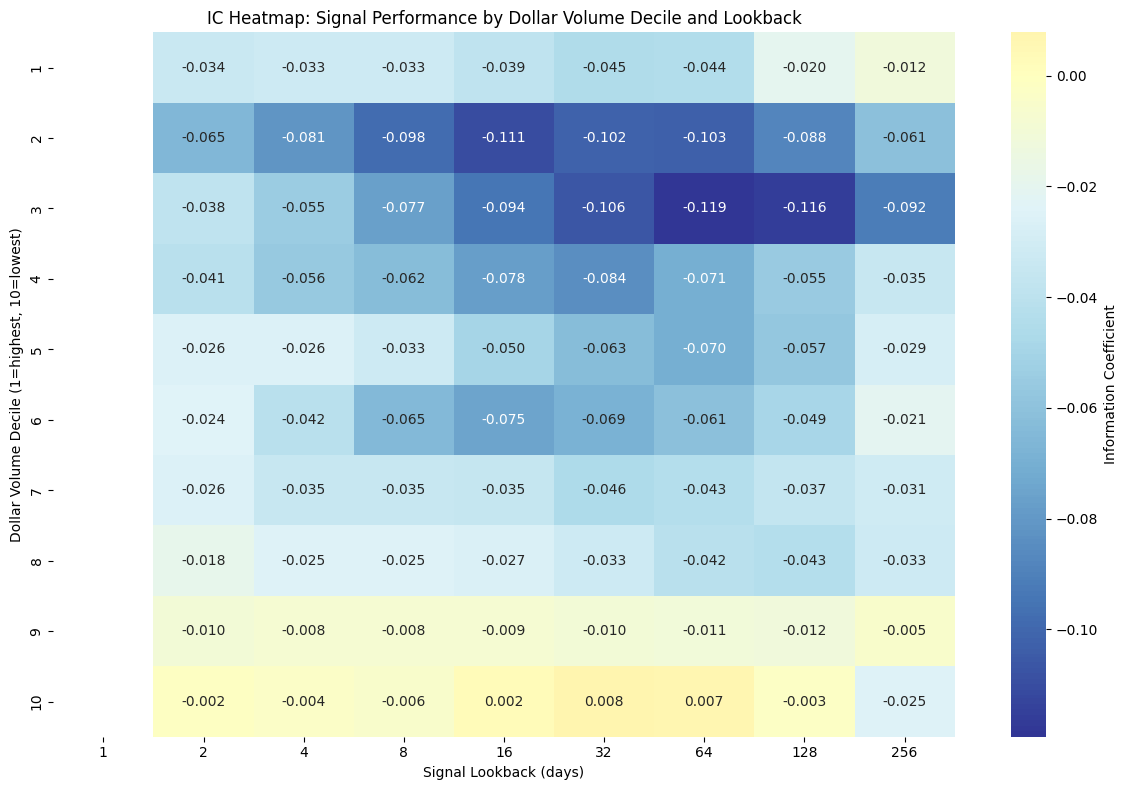


IC Summary by Decile:
dv_decile
1    -0.032437
2    -0.088756
3    -0.087192
4    -0.060280
5    -0.044246
6    -0.050666
7    -0.036033
8    -0.030615
9    -0.009096
10   -0.002764
dtype: float64

IC Summary by Lookback:
lookback
1           NaN
2     -0.028465
4     -0.036449
8     -0.044133
16    -0.051589
32    -0.055093
64    -0.055687
128   -0.047968
256   -0.034283
dtype: float64


In [15]:
# IC heatmap by dv_decile/lookback
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize results matrix
ic_heatmap_data = []

for l in lookbacks:
    print(f"Computing IC for lookback {l}")
    sig_col = f"signal_{l}d"
    ret_col = f"fwd_combined_return_10d_demeaned"  # Using fixed horizon like above
    
    # Compute IC by dv_decile for this lookback
    for decile in range(1, 11):  # dv_deciles 1-10
        decile_data = df_filtered[df_filtered['dv_decile'] == decile]
        
        if len(decile_data) > 10:  # Need minimum observations
            # Compute daily IC within this decile
            daily_ics = (
                decile_data
                .groupby("timestamp")[[sig_col, ret_col]]
                .apply(lambda g: g.iloc[:, 0].corr(g.iloc[:, 1], min_periods=2, method="spearman") if len(g) >= 2 else np.nan)
                .dropna()
            )
            
            if len(daily_ics) > 0:
                ic_mean = daily_ics.mean()
            else:
                ic_mean = np.nan
        else:
            ic_mean = np.nan
            
        ic_heatmap_data.append({
            'lookback': l,
            'dv_decile': decile,
            'IC': ic_mean
        })

# Convert to DataFrame and pivot for heatmap
ic_df = pd.DataFrame(ic_heatmap_data)
ic_pivot = ic_df.pivot(index='dv_decile', columns='lookback', values='IC')

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    ic_pivot,
    annot=True,
    fmt='.3f',
    cmap='RdYlBu_r',
    center=0,
    cbar_kws={'label': 'Information Coefficient'}
)
plt.title('IC Heatmap: Signal Performance by Dollar Volume Decile and Lookback')
plt.xlabel('Signal Lookback (days)')
plt.ylabel('Dollar Volume Decile (1=highest, 10=lowest)')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nIC Summary by Decile:")
print(ic_pivot.mean(axis=1).sort_index())
print("\nIC Summary by Lookback:")
print(ic_pivot.mean(axis=0))

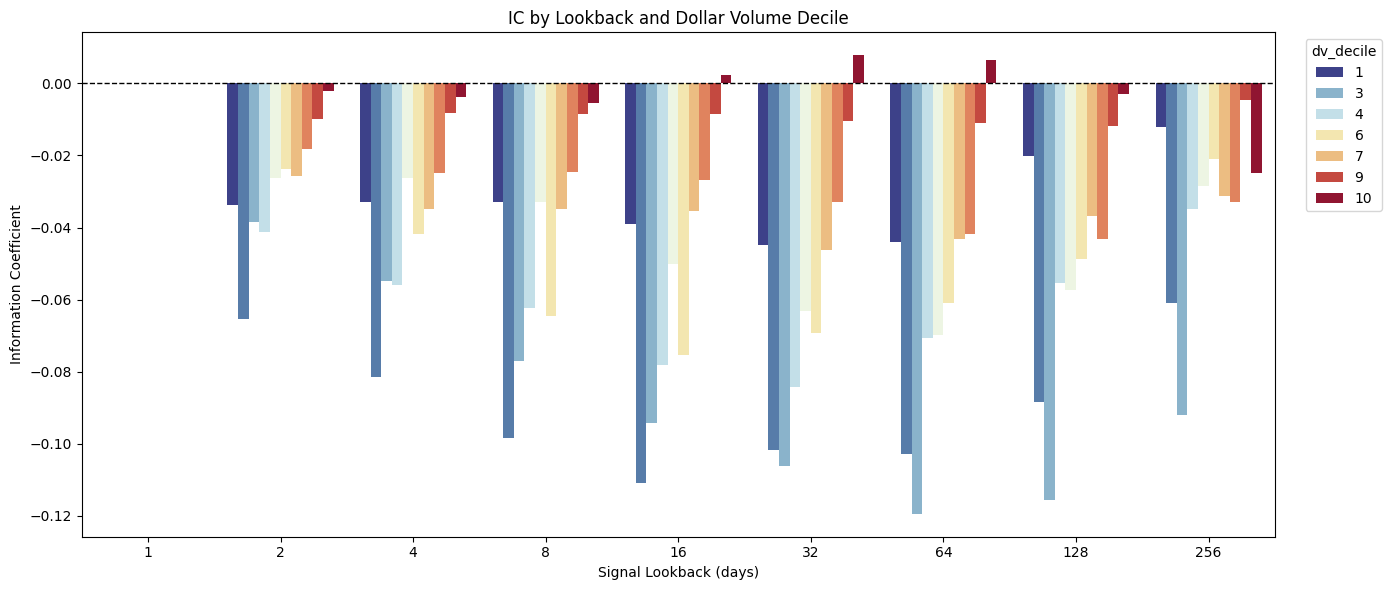

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten the pivoted table for plotting
ic_long = ic_pivot.reset_index().melt(id_vars="dv_decile", var_name="lookback", value_name="IC")

plt.figure(figsize=(14, 6))
sns.barplot(
    data=ic_long,
    x="lookback",
    y="IC",
    hue="dv_decile",
    palette="RdYlBu_r"
)

plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.title("IC by Lookback and Dollar Volume Decile")
plt.xlabel("Signal Lookback (days)")
plt.ylabel("Information Coefficient")
plt.legend(title="dv_decile", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


# Signal Selection

In [17]:
df_filtered['signal'] = df_filtered['signal_128d']

Holding-period estimator ``H = 1/avg_turnover`` assumes ``GMV = 1``.

In [18]:
# find turnover for future plots
df_filtered['weight'] = df_filtered.groupby('timestamp')['signal'].transform(
		lambda x: (x - x.mean()) / (x - x.mean()).abs().sum()
)
W = df_filtered.pivot(values='weight', columns='symbol', index='timestamp')
avg_holding_period = 1/W.diff().abs().sum(axis=1).mean()
print(f"Avg holding period: {avg_holding_period:.2f}")

Avg holding period: 4.54


# Signal distribution

Five-number summary:
  Min     : -1.0000
  25th %ile: -0.3673
  Median  : -0.1616
  75th %ile: 0.2412
  Max     : 1.0000


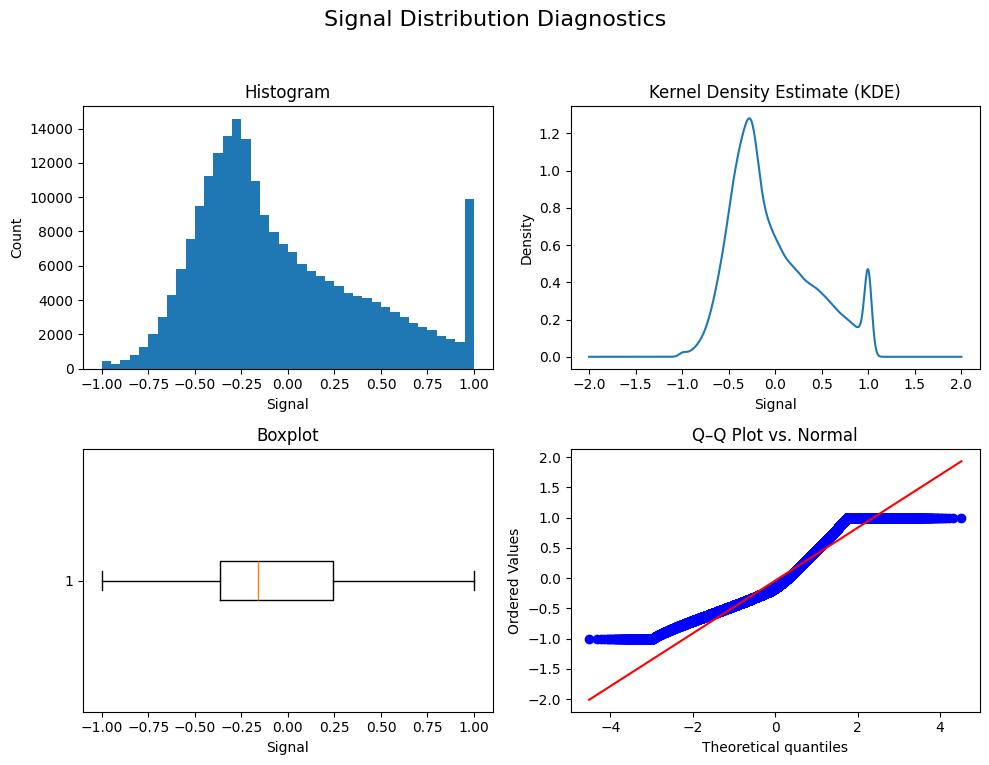

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

# extract and clean
signal = df_filtered['signal'].dropna()

# compute five-number summary
five_num = signal.quantile([0, .25, .5, .75, 1.0])
print("Five-number summary:")
print(f"  Min     : {five_num.loc[0.00]:.4f}")
print(f"  25th %ile: {five_num.loc[0.25]:.4f}")
print(f"  Median  : {five_num.loc[0.50]:.4f}")
print(f"  75th %ile: {five_num.loc[0.75]:.4f}")
print(f"  Max     : {five_num.loc[1.00]:.4f}")

# set up 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Signal Distribution Diagnostics', fontsize=16)

# 1. Histogram
axes[0, 0].hist(signal, bins=40)
axes[0, 0].set_title('Histogram')
axes[0, 0].set_xlabel('Signal')
axes[0, 0].set_ylabel('Count')

# 2. KDE
signal.plot.kde(ax=axes[0, 1])
axes[0, 1].set_title('Kernel Density Estimate (KDE)')
axes[0, 1].set_xlabel('Signal')

# 3. Boxplot
axes[1, 0].boxplot(signal, vert=False)
axes[1, 0].set_title('Boxplot')
axes[1, 0].set_xlabel('Signal')

# 4. Q–Q Plot
st.probplot(signal, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q–Q Plot vs. Normal')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Performance by ADV decile

C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\pandas\cor

Mean daily IC by dv_decile:
1.0    -0.030952
2.0    -0.068240
3.0    -0.076598
4.0    -0.061478
5.0    -0.061404
6.0    -0.050697
7.0    -0.060457
8.0    -0.053662
9.0    -0.045767
10.0   -0.028073
dtype: float64


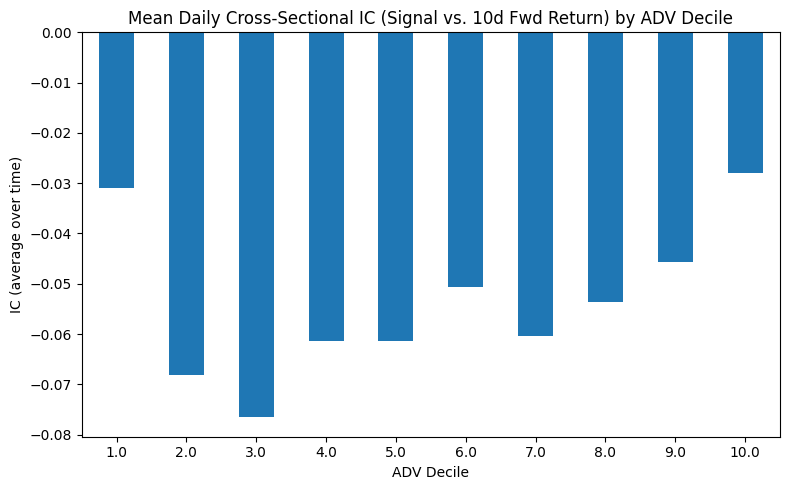

In [20]:
# Method 1: cross-sectional IC averaged over time, by dv_decile
import pandas as pd
import matplotlib.pyplot as plt

ic_by_decile = {}

target = "fwd_combined_return_1d_demeaned"

for decile, g in df_filtered.groupby("dv_decile"):
    # For each day in this decile, compute cross-sectional correlation
    daily_ic = (
        g.groupby("timestamp")[["signal", target]]
            .apply(lambda x: x["signal"].corr(x[target], min_periods=2, method = "spearman") if len(x) >= 2 else None)
            .dropna()
    )
    if len(daily_ic) > 0:
        ic_by_decile[decile] = daily_ic.mean()
    else:
        ic_by_decile[decile] = float("nan")

# Convert to Series for plotting
ic_series = pd.Series(ic_by_decile).sort_index()

print("Mean daily IC by dv_decile:")
print(ic_series)

# Plot
ic_series.plot(kind='bar', figsize=(8, 5))
plt.title('Mean Daily Cross-Sectional IC (Signal vs. 10d Fwd Return) by ADV Decile')
plt.xlabel('ADV Decile')
plt.ylabel('IC (average over time)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# Regressions by adv decile

C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\387569556.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g = g.groupby('timestamp', group_keys=False).apply(bin_within_day)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\387569556.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g = g.groupby('timestamp', group_keys=False).apply(bin_within_day)
C:\Users\itataurov.KORECAPIT

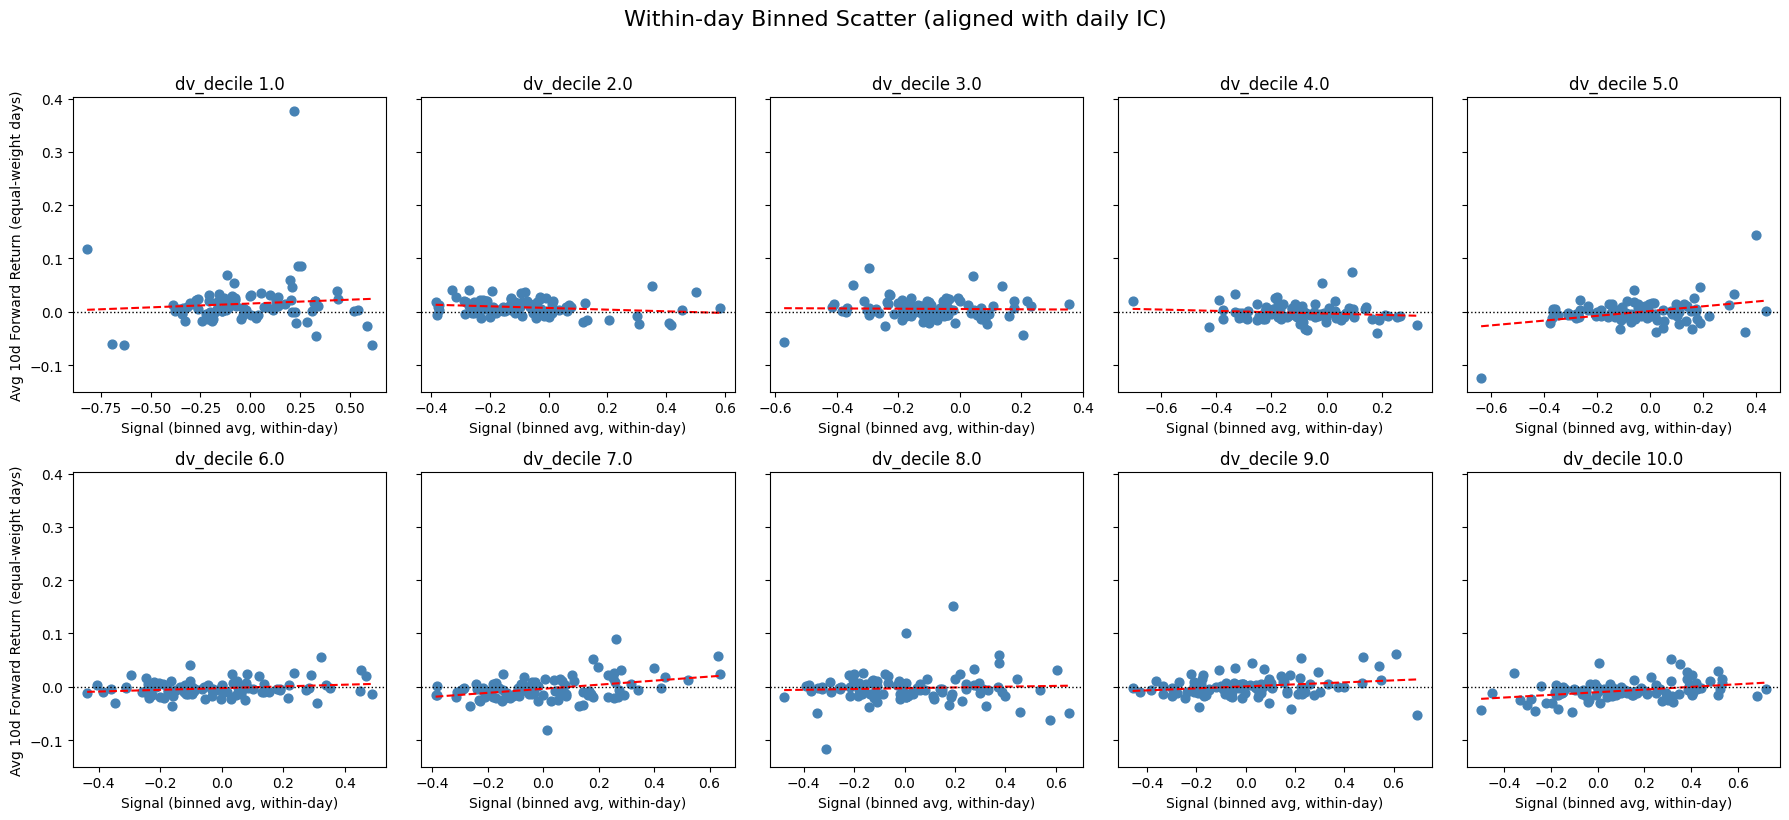

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

target = "fwd_combined_return_10d_demeaned"
signal_col = "signal"
n_bins = 100

# Set up subplots grid (2 rows x 5 cols = 10 panels)
fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharey=True)
axes = axes.flatten()

for i, decile in enumerate(sorted(df_filtered['dv_decile'].unique())):
    ax = axes[i]
    g = df_filtered.loc[df_filtered['dv_decile'] == decile,
                        ['timestamp', signal_col, target]].dropna()
    if g.empty:
        ax.set_title(f"Decile {decile} (no data)")
        continue

    # --- bin signals WITHIN each day ---
    def bin_within_day(df):
        df['signal_bin'] = pd.qcut(df[signal_col], n_bins,
                                   labels=False, duplicates="drop")
        return df

    g = g.groupby('timestamp', group_keys=False).apply(bin_within_day)

    # --- per-day bin averages ---
    per_day_bin_means = (
        g.groupby(['timestamp', 'signal_bin'])[[signal_col, target]]
         .mean()
         .reset_index()
    )

    # --- now average over days (equal-weight) ---
    bin_means = per_day_bin_means.groupby('signal_bin')[[signal_col, target]].mean()

    # Scatter plot: binned signal vs avg fwd return
    ax.scatter(bin_means[signal_col], bin_means[target],
               s=40, color="steelblue")

    # Fit linear regression line through the bins
    X = bin_means[[signal_col]].values
    y = bin_means[target].values
    if len(bin_means) > 1:
        reg = LinearRegression().fit(X, y)
        x_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
        y_line = reg.predict(x_line)
        ax.plot(x_line, y_line, color="red", linestyle="--")

    ax.axhline(0, color="black", linewidth=1, linestyle=":")
    ax.set_title(f"dv_decile {decile}")
    ax.set_xlabel("Signal (binned avg, within-day)")
    if i % 5 == 0:
        ax.set_ylabel("Avg 10d Forward Return (equal-weight days)")

plt.suptitle("Within-day Binned Scatter (aligned with daily IC)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


# create our single forecast

C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:47: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: rolling_beta(g, BETA_WIN))
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the gr

2021-01-02T00:00:00.000000000
2021-01-03T00:00:00.000000000
2021-01-04T00:00:00.000000000
2021-01-05T00:00:00.000000000
2021-01-06T00:00:00.000000000
2021-01-07T00:00:00.000000000
2021-01-08T00:00:00.000000000
2021-01-09T00:00:00.000000000
2021-01-10T00:00:00.000000000
2021-01-11T00:00:00.000000000
2021-01-12T00:00:00.000000000
2021-01-13T00:00:00.000000000
2021-01-14T00:00:00.000000000
2021-01-15T00:00:00.000000000
2021-01-16T00:00:00.000000000
2021-01-17T00:00:00.000000000
2021-01-18T00:00:00.000000000
2021-01-19T00:00:00.000000000
2021-01-20T00:00:00.000000000
2021-01-21T00:00:00.000000000
2021-01-22T00:00:00.000000000
2021-01-23T00:00:00.000000000
2021-01-24T00:00:00.000000000
2021-01-25T00:00:00.000000000
2021-01-26T00:00:00.000000000
2021-01-27T00:00:00.000000000
2021-01-28T00:00:00.000000000
2021-01-29T00:00:00.000000000
2021-01-30T00:00:00.000000000
2021-01-31T00:00:00.000000000
2021-02-01T00:00:00.000000000
2021-02-02T00:00:00.000000000
2021-02-03T00:00:00.000000000
2021-02-04

C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2021-02-06T00:00:00.000000000
2021-02-07T00:00:00.000000000
2021-02-08T00:00:00.000000000
2021-02-09T00:00:00.000000000
2021-02-10T00:00:00.000000000
2021-02-11T00:00:00.000000000
2021-02-12T00:00:00.000000000
2021-02-13T00:00:00.000000000
2021-02-14T00:00:00.000000000
2021-02-15T00:00:00.000000000
2021-02-16T00:00:00.000000000
2021-02-17T00:00:00.000000000
2021-02-18T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2021-02-19T00:00:00.000000000
2021-02-20T00:00:00.000000000
2021-02-21T00:00:00.000000000
2021-02-22T00:00:00.000000000
2021-02-23T00:00:00.000000000
2021-02-24T00:00:00.000000000
2021-02-25T00:00:00.000000000
2021-02-26T00:00:00.000000000
2021-02-27T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2021-02-28T00:00:00.000000000
2021-03-01T00:00:00.000000000
2021-03-02T00:00:00.000000000
2021-03-03T00:00:00.000000000
2021-03-04T00:00:00.000000000
2021-03-05T00:00:00.000000000
2021-03-06T00:00:00.000000000
2021-03-07T00:00:00.000000000
2021-03-08T00:00:00.000000000
2021-03-09T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2021-03-10T00:00:00.000000000
2021-03-11T00:00:00.000000000
2021-03-12T00:00:00.000000000
2021-03-13T00:00:00.000000000
2021-03-14T00:00:00.000000000
2021-03-15T00:00:00.000000000
2021-03-16T00:00:00.000000000
2021-03-17T00:00:00.000000000
2021-03-18T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-03-19T00:00:00.000000000
2021-03-20T00:00:00.000000000
2021-03-21T00:00:00.000000000
2021-03-22T00:00:00.000000000
2021-03-23T00:00:00.000000000
2021-03-24T00:00:00.000000000
2021-03-25T00:00:00.000000000
2021-03-26T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-03-27T00:00:00.000000000
2021-03-28T00:00:00.000000000
2021-03-29T00:00:00.000000000
2021-03-30T00:00:00.000000000
2021-03-31T00:00:00.000000000
2021-04-01T00:00:00.000000000
2021-04-02T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2021-04-03T00:00:00.000000000
2021-04-04T00:00:00.000000000
2021-04-05T00:00:00.000000000
2021-04-06T00:00:00.000000000
2021-04-07T00:00:00.000000000
2021-04-08T00:00:00.000000000
2021-04-09T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-04-10T00:00:00.000000000
2021-04-11T00:00:00.000000000
2021-04-12T00:00:00.000000000
2021-04-13T00:00:00.000000000
2021-04-14T00:00:00.000000000
2021-04-15T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-04-16T00:00:00.000000000
2021-04-17T00:00:00.000000000
2021-04-18T00:00:00.000000000
2021-04-19T00:00:00.000000000
2021-04-20T00:00:00.000000000
2021-04-21T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-04-22T00:00:00.000000000
2021-04-23T00:00:00.000000000
2021-04-24T00:00:00.000000000
2021-04-25T00:00:00.000000000
2021-04-26T00:00:00.000000000
2021-04-27T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2021-04-28T00:00:00.000000000
2021-04-29T00:00:00.000000000
2021-04-30T00:00:00.000000000
2021-05-01T00:00:00.000000000
2021-05-02T00:00:00.000000000
2021-05-03T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-05-04T00:00:00.000000000
2021-05-05T00:00:00.000000000
2021-05-06T00:00:00.000000000
2021-05-07T00:00:00.000000000
2021-05-08T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2021-05-09T00:00:00.000000000
2021-05-10T00:00:00.000000000
2021-05-11T00:00:00.000000000
2021-05-12T00:00:00.000000000
2021-05-13T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2021-05-14T00:00:00.000000000
2021-05-15T00:00:00.000000000
2021-05-16T00:00:00.000000000
2021-05-17T00:00:00.000000000
2021-05-18T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-05-19T00:00:00.000000000
2021-05-20T00:00:00.000000000
2021-05-21T00:00:00.000000000
2021-05-22T00:00:00.000000000
2021-05-23T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-05-24T00:00:00.000000000
2021-05-25T00:00:00.000000000
2021-05-26T00:00:00.000000000
2021-05-27T00:00:00.000000000
2021-05-28T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-05-29T00:00:00.000000000
2021-05-30T00:00:00.000000000
2021-05-31T00:00:00.000000000
2021-06-01T00:00:00.000000000
2021-06-02T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2021-06-03T00:00:00.000000000
2021-06-04T00:00:00.000000000
2021-06-05T00:00:00.000000000
2021-06-06T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-06-07T00:00:00.000000000
2021-06-08T00:00:00.000000000
2021-06-09T00:00:00.000000000
2021-06-10T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2021-06-11T00:00:00.000000000
2021-06-12T00:00:00.000000000
2021-06-13T00:00:00.000000000
2021-06-14T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-06-15T00:00:00.000000000
2021-06-16T00:00:00.000000000
2021-06-17T00:00:00.000000000
2021-06-18T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-06-19T00:00:00.000000000
2021-06-20T00:00:00.000000000
2021-06-21T00:00:00.000000000
2021-06-22T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-06-23T00:00:00.000000000
2021-06-24T00:00:00.000000000
2021-06-25T00:00:00.000000000
2021-06-26T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-06-27T00:00:00.000000000
2021-06-28T00:00:00.000000000
2021-06-29T00:00:00.000000000
2021-06-30T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-07-01T00:00:00.000000000
2021-07-02T00:00:00.000000000
2021-07-03T00:00:00.000000000
2021-07-04T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-07-05T00:00:00.000000000
2021-07-06T00:00:00.000000000
2021-07-07T00:00:00.000000000
2021-07-08T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2021-07-09T00:00:00.000000000
2021-07-10T00:00:00.000000000
2021-07-11T00:00:00.000000000
2021-07-12T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-07-13T00:00:00.000000000
2021-07-14T00:00:00.000000000
2021-07-15T00:00:00.000000000
2021-07-16T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2021-07-17T00:00:00.000000000
2021-07-18T00:00:00.000000000
2021-07-19T00:00:00.000000000
2021-07-20T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2021-07-21T00:00:00.000000000
2021-07-22T00:00:00.000000000
2021-07-23T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-07-24T00:00:00.000000000
2021-07-25T00:00:00.000000000
2021-07-26T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2021-07-27T00:00:00.000000000
2021-07-28T00:00:00.000000000
2021-07-29T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-07-30T00:00:00.000000000
2021-07-31T00:00:00.000000000
2021-08-01T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-08-02T00:00:00.000000000
2021-08-03T00:00:00.000000000
2021-08-04T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-08-05T00:00:00.000000000
2021-08-06T00:00:00.000000000
2021-08-07T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-08-08T00:00:00.000000000
2021-08-09T00:00:00.000000000
2021-08-10T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-08-11T00:00:00.000000000
2021-08-12T00:00:00.000000000
2021-08-13T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-08-14T00:00:00.000000000
2021-08-15T00:00:00.000000000
2021-08-16T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-08-17T00:00:00.000000000
2021-08-18T00:00:00.000000000
2021-08-19T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2021-08-20T00:00:00.000000000
2021-08-21T00:00:00.000000000
2021-08-22T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-08-23T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-08-24T00:00:00.000000000
2021-08-25T00:00:00.000000000
2021-08-26T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-08-27T00:00:00.000000000
2021-08-28T00:00:00.000000000
2021-08-29T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-08-30T00:00:00.000000000
2021-08-31T00:00:00.000000000
2021-09-01T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-09-02T00:00:00.000000000
2021-09-03T00:00:00.000000000
2021-09-04T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-09-05T00:00:00.000000000
2021-09-06T00:00:00.000000000
2021-09-07T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-09-08T00:00:00.000000000
2021-09-09T00:00:00.000000000
2021-09-10T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-09-11T00:00:00.000000000
2021-09-12T00:00:00.000000000
2021-09-13T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-09-14T00:00:00.000000000
2021-09-15T00:00:00.000000000
2021-09-16T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2021-09-17T00:00:00.000000000
2021-09-18T00:00:00.000000000
2021-09-19T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-09-20T00:00:00.000000000
2021-09-21T00:00:00.000000000
2021-09-22T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-09-23T00:00:00.000000000
2021-09-24T00:00:00.000000000
2021-09-25T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2021-09-26T00:00:00.000000000
2021-09-27T00:00:00.000000000
2021-09-28T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-09-29T00:00:00.000000000
2021-09-30T00:00:00.000000000
2021-10-01T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2021-10-02T00:00:00.000000000
2021-10-03T00:00:00.000000000
2021-10-04T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2021-10-05T00:00:00.000000000
2021-10-06T00:00:00.000000000
2021-10-07T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-10-08T00:00:00.000000000
2021-10-09T00:00:00.000000000
2021-10-10T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2021-10-11T00:00:00.000000000
2021-10-12T00:00:00.000000000
2021-10-13T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-10-14T00:00:00.000000000
2021-10-15T00:00:00.000000000
2021-10-16T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2021-10-17T00:00:00.000000000
2021-10-18T00:00:00.000000000
2021-10-19T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2021-10-20T00:00:00.000000000
2021-10-21T00:00:00.000000000
2021-10-22T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-10-23T00:00:00.000000000
2021-10-24T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-10-25T00:00:00.000000000
2021-10-26T00:00:00.000000000
2021-10-27T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2021-10-28T00:00:00.000000000
2021-10-29T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-10-30T00:00:00.000000000
2021-10-31T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-11-01T00:00:00.000000000
2021-11-02T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-11-03T00:00:00.000000000
2021-11-04T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-11-05T00:00:00.000000000
2021-11-06T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-11-07T00:00:00.000000000
2021-11-08T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-11-09T00:00:00.000000000
2021-11-10T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-11-11T00:00:00.000000000
2021-11-12T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-11-13T00:00:00.000000000
2021-11-14T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-11-15T00:00:00.000000000
2021-11-16T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-11-17T00:00:00.000000000
2021-11-18T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-11-19T00:00:00.000000000
2021-11-20T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-11-21T00:00:00.000000000
2021-11-22T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-11-23T00:00:00.000000000
2021-11-24T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-11-25T00:00:00.000000000
2021-11-26T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-11-27T00:00:00.000000000
2021-11-28T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-11-29T00:00:00.000000000
2021-11-30T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-12-01T00:00:00.000000000
2021-12-02T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-12-03T00:00:00.000000000
2021-12-04T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-12-05T00:00:00.000000000
2021-12-06T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-12-07T00:00:00.000000000
2021-12-08T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-12-09T00:00:00.000000000
2021-12-10T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-12-11T00:00:00.000000000
2021-12-12T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-12-13T00:00:00.000000000
2021-12-14T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-12-15T00:00:00.000000000
2021-12-16T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-12-17T00:00:00.000000000
2021-12-18T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-12-19T00:00:00.000000000
2021-12-20T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-12-21T00:00:00.000000000
2021-12-22T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-12-23T00:00:00.000000000
2021-12-24T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-12-25T00:00:00.000000000
2021-12-26T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-12-27T00:00:00.000000000
2021-12-28T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-12-29T00:00:00.000000000
2021-12-30T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2021-12-31T00:00:00.000000000
2022-01-01T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-01-02T00:00:00.000000000
2022-01-03T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-01-04T00:00:00.000000000
2022-01-05T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-01-06T00:00:00.000000000
2022-01-07T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-01-08T00:00:00.000000000
2022-01-09T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-01-10T00:00:00.000000000
2022-01-11T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-01-12T00:00:00.000000000
2022-01-13T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-01-14T00:00:00.000000000
2022-01-15T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-01-16T00:00:00.000000000
2022-01-17T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-01-18T00:00:00.000000000
2022-01-19T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-01-20T00:00:00.000000000
2022-01-21T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-01-22T00:00:00.000000000
2022-01-23T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-01-24T00:00:00.000000000
2022-01-25T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-01-26T00:00:00.000000000
2022-01-27T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-01-28T00:00:00.000000000
2022-01-29T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-01-30T00:00:00.000000000
2022-01-31T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-02-01T00:00:00.000000000
2022-02-02T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-02-03T00:00:00.000000000
2022-02-04T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-02-05T00:00:00.000000000
2022-02-06T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-02-07T00:00:00.000000000
2022-02-08T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-02-09T00:00:00.000000000
2022-02-10T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-02-11T00:00:00.000000000
2022-02-12T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-02-13T00:00:00.000000000
2022-02-14T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-02-15T00:00:00.000000000
2022-02-16T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-02-17T00:00:00.000000000
2022-02-18T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-02-19T00:00:00.000000000
2022-02-20T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-02-21T00:00:00.000000000
2022-02-22T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-02-23T00:00:00.000000000
2022-02-24T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-02-25T00:00:00.000000000
2022-02-26T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-02-27T00:00:00.000000000
2022-02-28T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-03-01T00:00:00.000000000
2022-03-02T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-03-03T00:00:00.000000000
2022-03-04T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-03-05T00:00:00.000000000
2022-03-06T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-03-07T00:00:00.000000000
2022-03-08T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-03-09T00:00:00.000000000
2022-03-10T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-03-11T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-03-12T00:00:00.000000000
2022-03-13T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-03-14T00:00:00.000000000
2022-03-15T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-03-16T00:00:00.000000000
2022-03-17T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-03-18T00:00:00.000000000
2022-03-19T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-03-20T00:00:00.000000000
2022-03-21T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-03-22T00:00:00.000000000
2022-03-23T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-03-24T00:00:00.000000000
2022-03-25T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-03-26T00:00:00.000000000
2022-03-27T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-03-28T00:00:00.000000000
2022-03-29T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-03-30T00:00:00.000000000
2022-03-31T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-04-01T00:00:00.000000000
2022-04-02T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-04-03T00:00:00.000000000
2022-04-04T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-04-05T00:00:00.000000000
2022-04-06T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-04-07T00:00:00.000000000
2022-04-08T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-04-09T00:00:00.000000000
2022-04-10T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-04-11T00:00:00.000000000
2022-04-12T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-04-13T00:00:00.000000000
2022-04-14T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-04-15T00:00:00.000000000
2022-04-16T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-04-17T00:00:00.000000000
2022-04-18T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-04-19T00:00:00.000000000
2022-04-20T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-04-21T00:00:00.000000000
2022-04-22T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-04-23T00:00:00.000000000
2022-04-24T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-04-25T00:00:00.000000000
2022-04-26T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-04-27T00:00:00.000000000
2022-04-28T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-04-29T00:00:00.000000000
2022-04-30T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-05-01T00:00:00.000000000
2022-05-02T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-05-03T00:00:00.000000000
2022-05-04T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-05-05T00:00:00.000000000
2022-05-06T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-05-07T00:00:00.000000000
2022-05-08T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-05-09T00:00:00.000000000
2022-05-10T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-05-11T00:00:00.000000000
2022-05-12T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-05-13T00:00:00.000000000
2022-05-14T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-05-15T00:00:00.000000000
2022-05-16T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-05-17T00:00:00.000000000
2022-05-18T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-05-19T00:00:00.000000000
2022-05-20T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-05-21T00:00:00.000000000
2022-05-22T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-05-23T00:00:00.000000000
2022-05-24T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-05-25T00:00:00.000000000
2022-05-26T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-05-27T00:00:00.000000000
2022-05-28T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-05-29T00:00:00.000000000
2022-05-30T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-05-31T00:00:00.000000000
2022-06-01T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-06-02T00:00:00.000000000
2022-06-03T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-06-04T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-06-05T00:00:00.000000000
2022-06-06T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-06-07T00:00:00.000000000
2022-06-08T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-06-09T00:00:00.000000000
2022-06-10T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-06-11T00:00:00.000000000
2022-06-12T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-06-13T00:00:00.000000000
2022-06-14T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-06-15T00:00:00.000000000
2022-06-16T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-06-17T00:00:00.000000000
2022-06-18T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-06-19T00:00:00.000000000
2022-06-20T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-06-21T00:00:00.000000000
2022-06-22T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-06-23T00:00:00.000000000
2022-06-24T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-06-25T00:00:00.000000000
2022-06-26T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-06-27T00:00:00.000000000
2022-06-28T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)


2022-06-29T00:00:00.000000000
2022-06-30T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-07-01T00:00:00.000000000
2022-07-02T00:00:00.000000000
2022-07-03T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-07-04T00:00:00.000000000
2022-07-05T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-07-06T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-07-07T00:00:00.000000000
2022-07-08T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)


2022-07-09T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-07-10T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-07-11T00:00:00.000000000
2022-07-12T00:00:00.000000000
2022-07-13T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-07-14T00:00:00.000000000
2022-07-15T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-07-16T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-07-17T00:00:00.000000000
2022-07-18T00:00:00.000000000
2022-07-19T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-07-20T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-07-21T00:00:00.000000000
2022-07-22T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)


2022-07-23T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-07-24T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-07-25T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-07-26T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-07-27T00:00:00.000000000
2022-07-28T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This beha

2022-07-29T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-07-30T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-07-31T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-01T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-02T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-03T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-04T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-05T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-06T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-07T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-08T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-09T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-10T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-11T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-12T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-13T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-14T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-15T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-16T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-17T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-18T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-19T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-20T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-21T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-22T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-23T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-24T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-25T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-26T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-27T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-28T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-29T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-30T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-08-31T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-01T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-02T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-03T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-04T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-05T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-06T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-07T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-08T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-09T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-10T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-11T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-12T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-13T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-14T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-15T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-16T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-17T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-18T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-19T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-20T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-21T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-22T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-23T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-24T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-25T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-26T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-27T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-28T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-29T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-09-30T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-01T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-02T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-03T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-04T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-05T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-06T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-07T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-08T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-09T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-10T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-11T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-12T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-13T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-14T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-15T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-16T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-17T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-18T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-19T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-20T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-21T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-22T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-23T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-24T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-25T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-26T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-27T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-28T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-29T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-30T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-10-31T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-01T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-02T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-03T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-04T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-05T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-06T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-07T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-08T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-09T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-10T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-11T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-12T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-13T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-14T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-15T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-16T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-17T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-18T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-19T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-20T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-21T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-22T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-23T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-24T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-25T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-26T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-27T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-28T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-29T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-11-30T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-01T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-02T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-03T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-04T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-05T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-06T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-07T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-08T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-09T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-10T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-11T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-12T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-13T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-14T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-15T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-16T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-17T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-18T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-19T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-20T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-21T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-22T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-23T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-24T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-25T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-26T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-27T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-28T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-29T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-30T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)
C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:87: RuntimeWarning: Mean of empty slice
  m = np.nanmean(a); s = np.nanstd(a, ddof=0)
C:\Users\itataurov.KORECAPITAL\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-12-31T00:00:00.000000000


C:\Users\itataurov.KORECAPITAL\AppData\Local\Temp\ipykernel_33680\1323577097.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_perp)


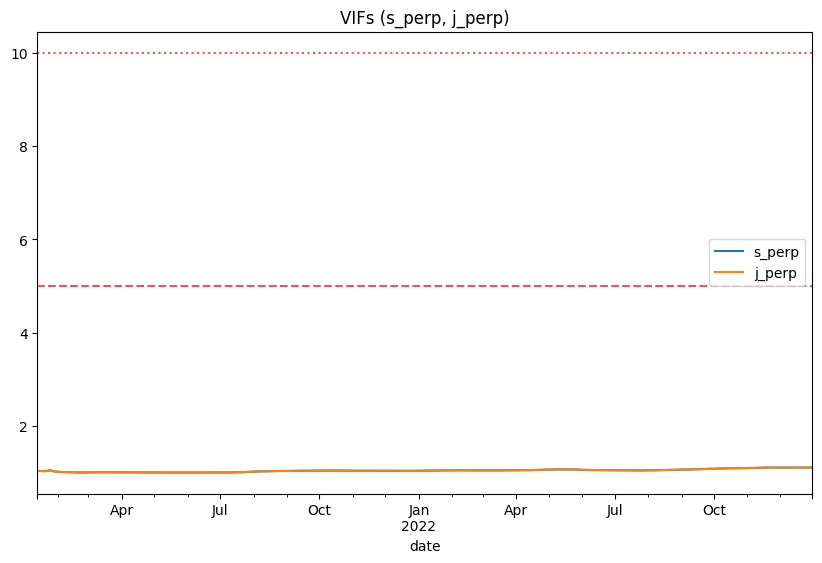

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit  # kept import for minimal diffs

df = df_filtered.copy()
df = df[df.timestamp<'2023-01-01']

# --- Build forecast_10d with Ridge + CV (no lookahead) ---
H = 10
target_col = f"fwd_combined_return_{H}d_demeaned"
adv_col = "size_score"

# Purged + Embargoed CV settings (minimal diffs)
PURGE_DAYS = H
EMBARGO_DAYS = H
N_SPLITS = 5

df = df.sort_values(["timestamp", "symbol"]).copy()
df["const"] = 1.0
df["timestamp64"] = df["timestamp"].to_numpy(dtype="datetime64[ns]")
df["forecast"] = np.nan
dates = np.sort(df["timestamp"].unique())

# ---------- Trailing market betas (no lookahead) ----------
BETA_WIN = 60  # days
if "ret1d" not in df.columns:
    if "close" in df.columns:
        df["ret1d"] = df.groupby("symbol")["close"].pct_change()
    else:
        raise ValueError("Need 'close' (or precomputed 'ret1d') to build market beta.")

mkt_ret = df.groupby("timestamp")["ret1d"].mean()
df["mkt_ret"] = df["timestamp"].map(mkt_ret)

def rolling_beta(g, win=BETA_WIN):
    x = g["mkt_ret"]; y = g["ret1d"]
    mx = x.rolling(win, min_periods=win).mean()
    my = y.rolling(win, min_periods=win).mean()
    cov = (x*y).rolling(win, min_periods=win).mean() - mx*my
    varx = (x*x).rolling(win, min_periods=win).mean() - mx*mx
    beta = cov / varx.replace(0, np.nan)
    return beta

df["mkt_beta"] = (
    df.groupby("symbol", group_keys=False)
      .apply(lambda g: rolling_beta(g, BETA_WIN))
)
df["mkt_beta_lag"] = df.groupby("symbol")["mkt_beta"].shift(1)  # no-lookahead

# ---------- Trailing volatility (no lookahead) ----------
VOL_WIN = 30  # days
df["vol_roll"] = (
    df.groupby("symbol")["ret1d"]
      .rolling(VOL_WIN, min_periods=VOL_WIN).std()
      .reset_index(level=0, drop=True)
)
df["vol_lag"] = df.groupby("symbol")["vol_roll"].shift(1)  # no-lookahead

# ----------------------------------------------------------------------

X_full = df[["const", "signal", adv_col]].to_numpy()  # for valid mask only
y_full = df[target_col].to_numpy()
valid = ~np.isnan(y_full) & ~np.isnan(X_full).any(axis=1)

alphas = np.logspace(-6, 7, 20)
I = np.eye(3); I[0, 0] = 0.0  # intercept not penalized (const, s_perp, j_perp)

def ridge_fit(X, y, a):
    return np.linalg.solve(X.T @ X + a * I, X.T @ y)

def compute_vif(X):
    vifs = []
    k = X.shape[1]
    for j in range(k):
        yj = X[:, j]
        Xj = np.delete(X, j, axis=1)
        beta, *_ = np.linalg.lstsq(Xj, yj, rcond=None)
        yj_hat = Xj @ beta
        ss_res = np.sum((yj - yj_hat) ** 2)
        ss_tot = np.sum((yj - yj.mean()) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else 0
        vifs.append(np.inf if r2 >= 1 else 1.0 / (1 - r2))
    return vifs

def cs_zscore(a):
    m = np.nanmean(a); s = np.nanstd(a, ddof=0)
    return (a - m) / (s if s > 0 else 1.0)

def cs_residual(y, Z):
    Z = np.asarray(Z)
    b, *_ = np.linalg.lstsq(Z, y, rcond=None)
    return y - Z @ b

def purged_embargoed_time_splits(ts, n_splits=N_SPLITS, purge_days=PURGE_DAYS, embargo_days=EMBARGO_DAYS):
    n = len(ts)
    indices = np.arange(n)
    fold_sizes = np.full(n_splits, n // n_splits); fold_sizes[: n % n_splits] += 1
    bounds = []; start = 0
    for fs in range(len(fold_sizes)):
        stop = start + fold_sizes[fs]; bounds.append((start, stop)); start = stop
    for (va_start, va_stop) in bounds:
        if va_start >= va_stop: continue
        va_idx = indices[va_start:va_stop]
        va_start_time = ts[va_start]; va_end_time = ts[va_stop - 1]
        purge_cutoff   = va_start_time - np.timedelta64(purge_days, 'D')
        embargo_cutoff = va_end_time   + np.timedelta64(embargo_days, 'D')
        tr_mask = (ts < purge_cutoff) | (ts > embargo_cutoff)
        tr_idx = indices[tr_mask]
        if tr_idx.size == 0: continue
        yield tr_idx, va_idx

# tracking
alphas_chosen = []
betas = []
vif_list = []

for d in dates:
    print(d)
    cutoff = np.datetime64(pd.Timestamp(d) - pd.Timedelta(days=H))
    tr_mask = (df["timestamp64"] <= cutoff) & valid
    if tr_mask.sum() < 100:
        continue

    # --- PER-DATE residualization vs [1, size_cs, beta_cs, vol_cs] ---
    g_tr = df.loc[tr_mask, ["timestamp", "signal", adv_col, "mkt_beta_lag", "vol_lag"]]

    def make_perp(block):
        s = block["signal"].to_numpy()
        z = block[adv_col].to_numpy()
        b = block["mkt_beta_lag"].to_numpy()
        v = block["vol_lag"].to_numpy()

        s_cs = cs_zscore(s)
        z_cs = cs_zscore(z)
        b_cs = cs_zscore(b); b_cs = np.where(np.isfinite(b_cs), b_cs, 0.0)
        v_cs = cs_zscore(v); v_cs = np.where(np.isfinite(v_cs), v_cs, 0.0)

        # neutralize to intercept, size, market beta, and volatility
        Zbasis = np.column_stack([np.ones_like(z_cs), z_cs, b_cs, v_cs])
        s_perp = cs_residual(s_cs, Zbasis)
        j_perp = cs_residual(s_cs * z_cs, Zbasis)  # keep slope-vs-size flexibility
        return pd.DataFrame({"s_perp": s_perp, "j_perp": j_perp}, index=block.index)

    perp_tr = (
        g_tr.groupby("timestamp", sort=False)
            .apply(make_perp)
            .reset_index(level=0, drop=True)
            .loc[df.index[tr_mask]]
    )

    X_tr = np.column_stack([np.ones(perp_tr.shape[0]),
                            perp_tr["s_perp"].to_numpy(),
                            perp_tr["j_perp"].to_numpy()])
    y_tr = y_full[tr_mask]
    ts_tr = df.loc[tr_mask, "timestamp64"].to_numpy()

    # --- Standardize non-intercept cols ---
    means = X_tr[:, 1:].mean(axis=0)
    stds = X_tr[:, 1:].std(axis=0, ddof=0); stds[stds == 0] = 1.0
    def standardize(X):
        Xs = X.copy(); Xs[:, 1:] = (Xs[:, 1:] - means) / stds; return Xs
    X_tr_std = standardize(X_tr)

    # --- VIFs on perp features ---
    vifs = compute_vif(X_tr_std[:, 1:])
    vif_list.append({"date": d, "s_perp": vifs[0], "j_perp": vifs[1]})

    # --- Purged + Embargoed CV ---
    best_a, best_mse = None, np.inf
    for a in alphas:
        mses = []
        for tr_idx, va_idx in purged_embargoed_time_splits(ts_tr):
            b_cv = ridge_fit(X_tr_std[tr_idx], y_tr[tr_idx], a)
            err = X_tr_std[va_idx] @ b_cv - y_tr[va_idx]
            mses.append(np.mean(err * err))
        if mses:
            mse = np.mean(mses)
            if mse < best_mse:
                best_mse, best_a = mse, a

    if best_a is None:
        continue
    b = ridge_fit(X_tr_std, y_tr, best_a)

    # --- Predict current day with same residualization (1, size_cs, beta_cs, vol_cs) ---
    te_mask = df["timestamp"] == d
    if te_mask.any():
        blk = df.loc[te_mask, ["signal", adv_col, "mkt_beta_lag", "vol_lag"]]
        s_te = blk["signal"].to_numpy()
        z_te = blk[adv_col].to_numpy()
        b_te = blk["mkt_beta_lag"].to_numpy()
        v_te = blk["vol_lag"].to_numpy()

        s_cs_te = cs_zscore(s_te)
        z_cs_te = cs_zscore(z_te)
        b_cs_te = cs_zscore(b_te); b_cs_te = np.where(np.isfinite(b_cs_te), b_cs_te, 0.0)
        v_cs_te = cs_zscore(v_te); v_cs_te = np.where(np.isfinite(v_cs_te), v_cs_te, 0.0)

        Zbasis_te = np.column_stack([np.ones_like(z_cs_te), z_cs_te, b_cs_te, v_cs_te])
        s_perp_te = cs_residual(s_cs_te, Zbasis_te)
        j_perp_te = cs_residual(s_cs_te * z_cs_te, Zbasis_te)

        X_te = np.column_stack([np.ones(te_mask.sum()), s_perp_te, j_perp_te])
        X_te_std = standardize(X_te)
        yhat = X_te_std @ b
        df.loc[te_mask, "forecast"] = yhat

    # store tracking
    alphas_chosen.append({"date": d, "alpha": best_a})
    betas.append({"date": d, "const": b[0], "s_perp": b[1], "j_perp": b[2]})

# After loop
alphas_df = pd.DataFrame(alphas_chosen).set_index("date")
betas_df   = pd.DataFrame(betas).set_index("date")
vif_df     = pd.DataFrame(vif_list).set_index("date")

if not vif_df.empty:
    vif_df.plot(title="VIFs (s_perp, j_perp)", figsize=(10, 6))
    plt.axhline(5, color="red", linestyle="--", alpha=0.7)
    plt.axhline(10, color="red", linestyle=":", alpha=0.7)
    plt.show()


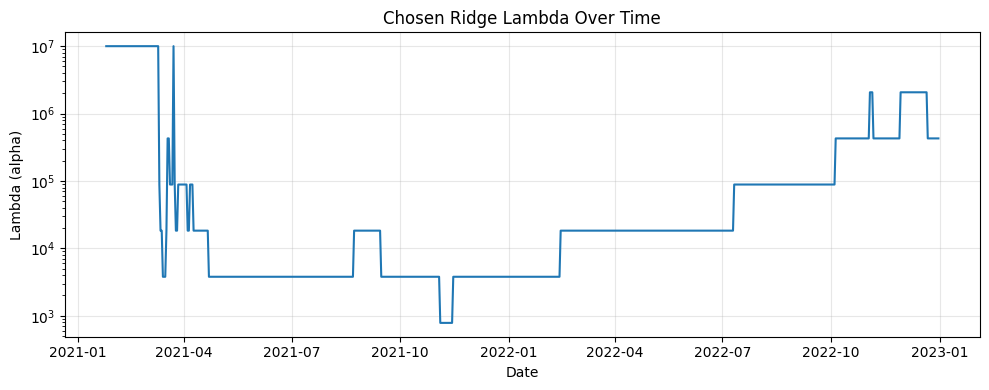

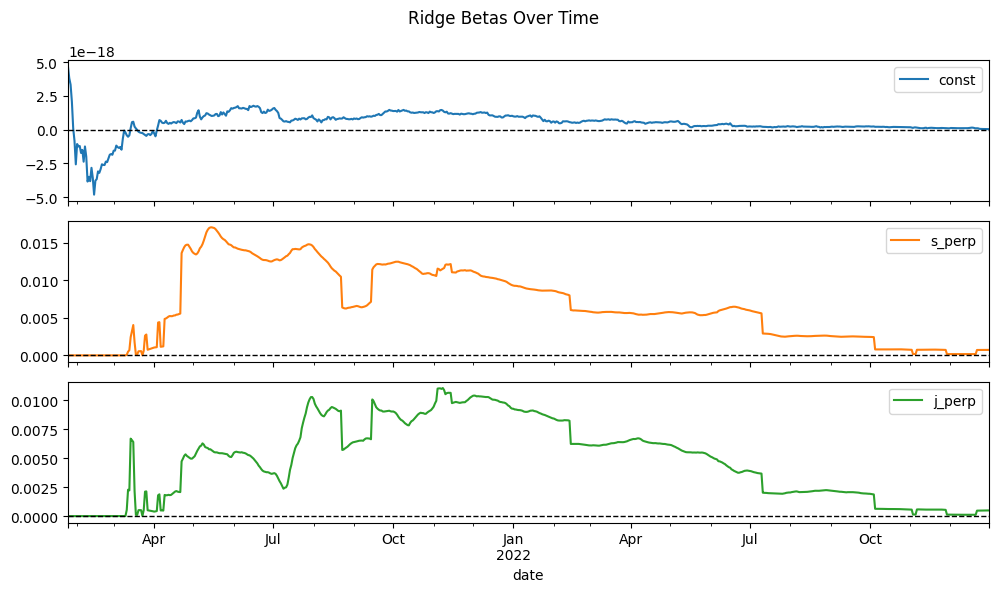

In [64]:

# convert tracking results
alphas_df = pd.DataFrame(alphas_chosen).set_index("date")
betas_df = pd.DataFrame(betas).set_index("date")

# plot chosen ridge lambda
plt.figure(figsize=(10,4))
plt.plot(alphas_df.index, alphas_df["alpha"])
plt.yscale("log")
plt.title("Chosen Ridge Lambda Over Time")
plt.xlabel("Date")
plt.ylabel("Lambda (alpha)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# plot betas
betas_df.plot(subplots=True, figsize=(10,6), title="Ridge Betas Over Time")
# horiz lines at 0
for ax in plt.gcf().axes:
    ax.axhline(0, color="black", linewidth=1, linestyle="--")
plt.tight_layout()
plt.show()


# Decay

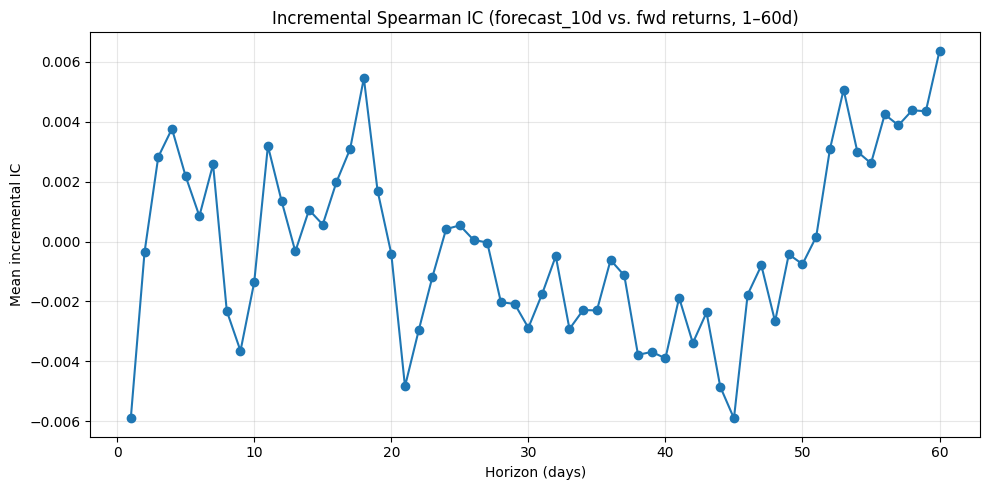

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Setup ---
horizons = np.arange(1, 61)
rets = {h: df[f"fwd_combined_return_{h}d_demeaned"].to_numpy() for h in horizons}
fcast = df["forecast"].to_numpy()
timestamps = df["timestamp"].to_numpy()

# Precompute row indices per day (so we don't re-scan)
day_to_idx = {}
for i, d in enumerate(timestamps):
    day_to_idx.setdefault(d, []).append(i)

# Convert lists to NumPy arrays for speed
for d in day_to_idx:
    day_to_idx[d] = np.array(day_to_idx[d], dtype=int)

# --- Function to compute cross-sectional Spearman fast ---
from scipy.stats import rankdata

def daily_spearman(x, y):
    # rankdata assigns average ranks, handles ties
    rx = rankdata(x)
    ry = rankdata(y)
    return np.corrcoef(rx, ry)[0,1]

# --- Incremental IC per horizon ---
decay = {}

for i, H in enumerate(horizons):
    if i == 0:
        inc_ret = rets[H]
    else:
        inc_ret = rets[H] - rets[horizons[i-1]]

    daily_vals = []
    for d, idxs in day_to_idx.items():
        if len(idxs) < 2:
            continue
        x = fcast[idxs]
        y = inc_ret[idxs]
        if np.all(np.isnan(y)) or np.all(np.isnan(x)):
            continue
        mask = (~np.isnan(x)) & (~np.isnan(y))
        if mask.sum() < 2:
            continue
        daily_vals.append(daily_spearman(x[mask], y[mask]))

    decay[H] = np.nanmean(daily_vals) if daily_vals else np.nan

decay_series = pd.Series(decay)

# --- Plot ---
plt.figure(figsize=(10,5))
plt.plot(decay_series.index, decay_series.values, marker='o')
plt.title("Incremental Spearman IC (forecast_10d vs. fwd returns, 1–60d)")
plt.xlabel("Horizon (days)")
plt.ylabel("Mean incremental IC")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Signal stability over time

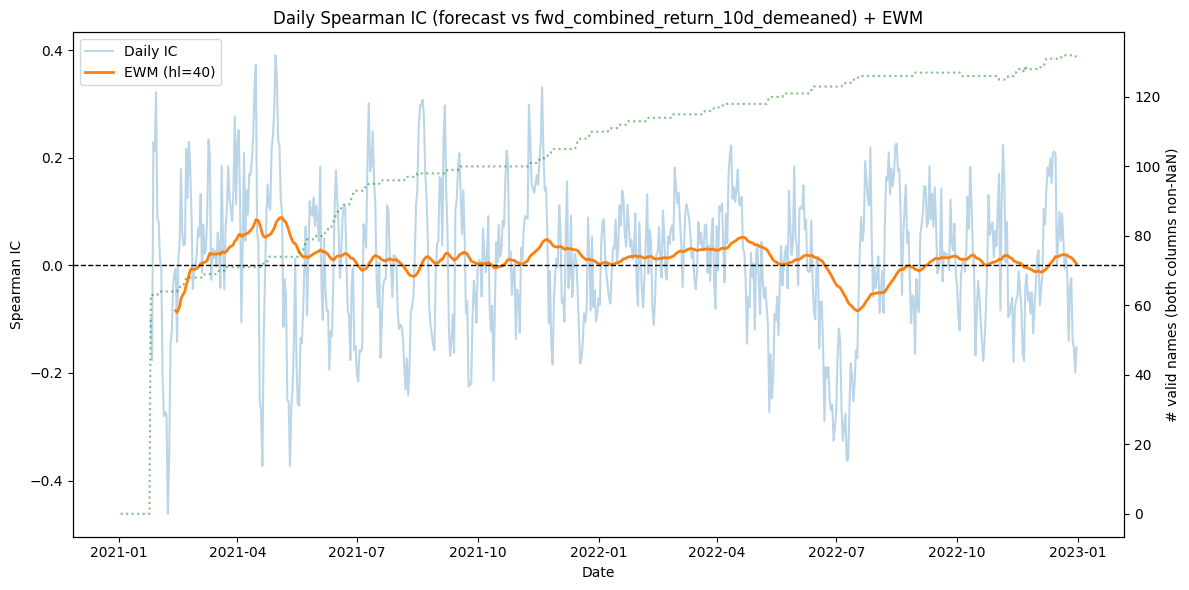

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import rankdata

ret_col = "fwd_combined_return_10d_demeaned"

# All dates present in the panel
all_dates = np.sort(df["timestamp"].unique())

# Precompute row indices per date (fast, avoids repeated groupby)
idx_map = df.groupby("timestamp", sort=True).indices

# Count valid pairs per date (both forecast & return non-NaN)
valid_pair = df[["forecast", ret_col]].notna().all(axis=1)
valid_pairs_per_day = pd.Series(valid_pair, index=df.index).groupby(df["timestamp"]).sum()
valid_pairs_per_day = valid_pairs_per_day.reindex(all_dates, fill_value=0)

def cs_spearman_for_idxs(idxs: np.ndarray) -> float:
    x = df["forecast"].to_numpy()[idxs]
    y = df[ret_col].to_numpy()[idxs]
    m = (~np.isnan(x)) & (~np.isnan(y))
    if m.sum() < 2:
        return np.nan
    rx = rankdata(x[m])
    ry = rankdata(y[m])
    return float(np.corrcoef(rx, ry)[0, 1])

# Daily IC series over ALL dates (NaNs kept instead of dropped)
ics_daily = pd.Series(index=all_dates, dtype=float)
for d in all_dates:
    idxs = np.asarray(idx_map.get(d, []), dtype=int)
    ics_daily.loc[d] = cs_spearman_for_idxs(idxs)

# Smooth with EWM (tune halflife/min_periods as you like)
ics_ewm = ics_daily.ewm(halflife=40, min_periods=20).mean()

# ---- Plot ----
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(ics_daily.index, ics_daily.values, alpha=0.3, label="Daily IC")
ax1.plot(ics_ewm.index, ics_ewm.values, linewidth=2, label="EWM (hl=40)")
ax1.axhline(0, color="black", lw=1, ls="--")
ax1.set_title(f"Daily Spearman IC (forecast vs {ret_col}) + EWM")
ax1.set_xlabel("Date")
ax1.set_ylabel("Spearman IC")
ax1.legend(loc="upper left")

# Overlay valid pair counts (helps explain stops)
ax2 = ax1.twinx()
ax2.plot(valid_pairs_per_day.index, valid_pairs_per_day.values, ls=":", alpha=0.5, color="green")
ax2.set_ylabel("# valid names (both columns non-NaN)")

plt.tight_layout()
plt.show()


# Systematic LS backtest

# Factor exposures (Should be ~0 due to gram-schmidt procedure)

Sharpe for forecast: 0.38
Vol: 25.90%


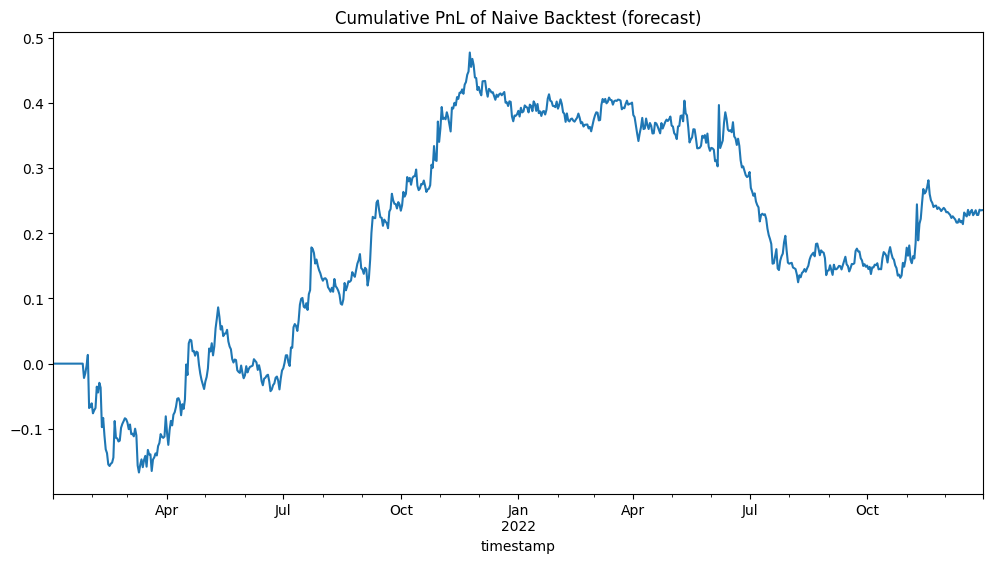

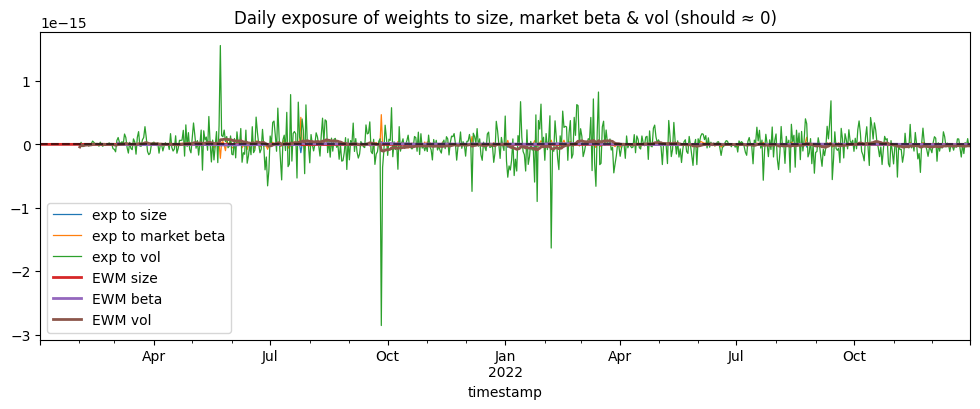

In [63]:
# stupid backtest
forecasts = [f"forecast"]
for forecast_name in forecasts:
    df_bt = df[['timestamp', 'symbol', 'size_score', 'mkt_beta_lag', 'vol_lag',
                forecast_name, 'close']].copy()
    df_bt['return'] = df_bt.groupby('symbol')['close'].pct_change()

    # cross-sectionally demean forecasts, scale to 1 gross
    df_bt['position'] = df_bt.groupby('timestamp')[forecast_name] \
        .transform(lambda x: (x - x.mean()) / (x - x.mean()).abs().sum())

    # wide pivots
    W = df_bt.pivot(values='position',   columns='symbol', index='timestamp')  # weights
    R = df_bt.pivot(values='return',     columns='symbol', index='timestamp')  # returns
    Z = df_bt.pivot(values='size_score', columns='symbol', index='timestamp')  # size
    B = df_bt.pivot(values='mkt_beta_lag', columns='symbol', index='timestamp')  # market beta
    V = df_bt.pivot(values='vol_lag',   columns='symbol', index='timestamp')  # volatility

    # --- PnL ---
    P = (W.shift() * R).sum(axis=1).fillna(0)   # daily pnl
    P.cumsum().plot(figsize=(12,6))
    plt.title(f"Cumulative PnL of Naive Backtest ({forecast_name})")
    print(f"Sharpe for {forecast_name}: {P.mean()/P.std()*np.sqrt(252):.2f}")
    print(f"Vol: {P.std()*np.sqrt(365):.2%}")

    # --- Neutrality checks ---
    Zc = Z.sub(Z.mean(axis=1), axis=0)
    Bc = B.sub(B.mean(axis=1), axis=0)
    Vc = V.sub(V.mean(axis=1), axis=0)

    common = W.columns.intersection(Zc.columns).intersection(Bc.columns).intersection(Vc.columns)
    Wc, Zc, Bc, Vc = W[common], Zc[common], Bc[common], Vc[common]

    beta_size = (Wc*Zc).sum(axis=1) / (Zc.pow(2)).sum(axis=1).replace(0, np.nan)
    beta_mkt  = (Wc*Bc).sum(axis=1) / (Bc.pow(2)).sum(axis=1).replace(0, np.nan)
    beta_vol  = (Wc*Vc).sum(axis=1) / (Vc.pow(2)).sum(axis=1).replace(0, np.nan)

    fig, ax = plt.subplots(figsize=(12,4))
    beta_size.plot(ax=ax, lw=0.9, label="exp to size")
    beta_mkt.plot(ax=ax,  lw=0.9, label="exp to market beta")
    beta_vol.plot(ax=ax,  lw=0.9, label="exp to vol")
    beta_size.ewm(halflife=20).mean().plot(ax=ax, lw=2, label="EWM size")
    beta_mkt.ewm(halflife=20).mean().plot(ax=ax,  lw=2, label="EWM beta")
    beta_vol.ewm(halflife=20).mean().plot(ax=ax,  lw=2, label="EWM vol")
    ax.axhline(0, color='k', ls='--', alpha=0.6)
    ax.set_title("Daily exposure of weights to size, market beta & vol (should ≈ 0)")
    ax.legend()
